In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
import re
import string
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay, roc_auc_score
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/Sentiment Analysis/Training/scored_tweets_total.csv", usecols=["text", "Sentiment"])
df1 = df1[df1['Sentiment'] != 0]
df1['Sentiment'].value_counts()

 1    8302
-1     869
Name: Sentiment, dtype: int64

In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/Sentiment Analysis/Training/stock_data.csv")
df2.columns = ["text", "Sentiment"]
df2['Sentiment'].value_counts()

 1    3685
-1    2106
Name: Sentiment, dtype: int64

In [ ]:
df3 = pd.read_csv("/content/drive/MyDrive/Sentiment Analysis/Training/stock_tweet_sentiment.csv", usecols =["text", "Sentiment"])
df3 = df3[df3['Sentiment'] != 0]
df3['Sentiment'].value_counts()

 1    8512
-1    2598
Name: Sentiment, dtype: int64

In [ ]:
df4 = pd.read_csv("/content/drive/MyDrive/Sentiment Analysis/Training/tweets_labelled.csv",on_bad_lines='skip', sep = ';', usecols=["text", "sentiment"])
df4['Sentiment'] = df4['sentiment'].replace(["positive", "neutral", "negative"],[1, 0, -1])
df4.drop(['sentiment'], axis=1,inplace=True)
df4 = df4[df4['Sentiment'] != 0]
df4.dropna(inplace=True)
df4['Sentiment'].value_counts()

 1.0    528
-1.0    348
Name: Sentiment, dtype: int64

In [ ]:
frames = [df1, df2, df3, df4]
data = pd.concat(frames)
data

,text,Sentiment
2,$AXTG Big OTC % Gainer!🚀🚀🚀,1.0
3,Today’s Top Penny Stock Gainers\n\n$LTTGF $AXT...,1.0
4,RT @GetScanz: Today’s Top Penny Stock Gainers\...,1.0
5,RT @GetScanz: Today’s Top Penny Stock Gainers\...,1.0
6,That is a great point! NFT is huge and $HMBL h...,1.0
...,...,...
1292,Q3 2020 EPS Estimates for Ball Co. $BLL Increa...,1.0
1295,#stocks back from the recovery room: https://t...,1.0
1296,RT @MacroCharts: Breadth – expanding last week...,1.0
1298,$AAPL $QQQ Top may now be in. https://t.co/iNK...,1.0


In [ ]:
#Preprocessing tweets
def process_tweet(tweet):
    #Remove old style retweet text "RT"
    tweet2 = re.sub(r'^RT[\s]','', tweet)

    #Remove numbers
    tweet2 = re.sub('\d+','',tweet2)
    
    #Remove hyperlinks
    tweet2 = re.sub(r'https?:\/\/.*[\r\n]*','', tweet2)
    
    #Remove hastags
    #Only removing the hash # sign from the word
    tweet2 = re.sub(r'#','',tweet2)
        
    # instantiate tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    
    # tokenize tweets
    tweet_tokens = tokenizer.tokenize(tweet2)    
        
    #Import the english stop words list from NLTK
    stopwords_english = stopwords.words('english')
    stopwords_english.append('nifty')
    
    #Creating a list of words without stopwords
    tweets_clean = []
    for word in tweet_tokens:
        if word not in stopwords_english and word not in string.punctuation:
            tweets_clean.append(word)
    
    lemmatizer = WordNetLemmatizer()
        # Create the lemmatized list
    lemmatized = []
    for word in tweets_clean:
      # Lemmatize and append 
      lemmatized.append(lemmatizer.lemmatize(word))
        
    return " ".join(lemmatized)

In [ ]:
data

,text,Sentiment
2,$AXTG Big OTC % Gainer!🚀🚀🚀,1.0
3,Today’s Top Penny Stock Gainers\n\n$LTTGF $AXT...,1.0
4,RT @GetScanz: Today’s Top Penny Stock Gainers\...,1.0
5,RT @GetScanz: Today’s Top Penny Stock Gainers\...,1.0
6,That is a great point! NFT is huge and $HMBL h...,1.0
...,...,...
1292,Q3 2020 EPS Estimates for Ball Co. $BLL Increa...,1.0
1295,#stocks back from the recovery room: https://t...,1.0
1296,RT @MacroCharts: Breadth – expanding last week...,1.0
1298,$AAPL $QQQ Top may now be in. https://t.co/iNK...,1.0


In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['text'])
vectorizer.get_feature_names_out()

array(['00', '000', '0000', ..., '５名に５５５５vips', '５５名に５５５vips', '𝗕𝗘𝗧𝗔'],
      dtype=object)

In [ ]:
X = pd.DataFrame(X)
X

,0
0,"(0, 6812)\t1\n (0, 7541)\t1\n (0, 25071)\t..."
1,"(0, 6812)\t1\n (0, 32763)\t1\n (0, 32825)\..."
2,"(0, 6812)\t1\n (0, 32763)\t1\n (0, 32825)\..."
3,"(0, 6812)\t1\n (0, 32763)\t1\n (0, 32825)\..."
4,"(0, 17349)\t1\n (0, 9740)\t1\n (0, 32310)\..."
...,...
26943,"(0, 17349)\t1\n (0, 9740)\t2\n (0, 14683)\..."
26944,"(0, 17349)\t2\n (0, 9740)\t2\n (0, 32315)\..."
26945,"(0, 28964)\t1\n (0, 18094)\t1\n (0, 6283)\..."
26946,"(0, 32825)\t1\n (0, 17349)\t1\n (0, 9740)\..."


In [ ]:
# Split into training and testing data
y = data['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

In [ ]:
pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

TypeError: ignored

In [ ]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

Accuracy Score:  0.8708719851576995


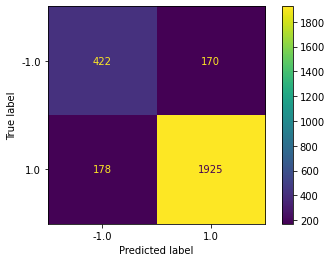

In [ ]:
y_pred = clf.predict(X_test)
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

[[4.54979040e-07 9.99999545e-01]
 [1.22298140e-01 8.77701860e-01]
 [7.06494760e-03 9.92935052e-01]
 ...
 [9.99806874e-01 1.93126159e-04]
 [9.30758009e-01 6.92419913e-02]
 [2.58581489e-01 7.41418511e-01]]


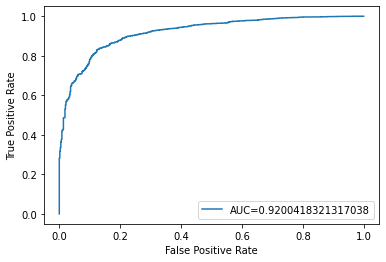

In [ ]:
pred = clf.predict_proba(X_test)
print(pred)
fpr, tpr, thresholds = roc_curve(y_test, pred[:,1])
auc = roc_auc_score(y_test, pred[:,1])
plt.plot(fpr, tpr,label="AUC="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/nifty50tweets.csv')
df.rename(columns = {'Text':'Tweet'}, inplace = True)
df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,Date Created,Number of Likes,Tweet
0,0,2022-10-12,11.0,Domestic equity market behaved decoupled from ...
1,1,2022-10-12,0.0,💰FII &amp; DII Buying &amp; Selling in the cas...
2,2,2022-10-12,30.0,NIFTY 50 (Daily): Three interesting patterns w...
3,3,2022-10-12,37.0,12-10-2022\n\nAlthough the indices re bounded ...
4,4,2022-10-12,9.0,Karur Vysya bank #karurvysya \nThis is one of ...
...,...,...,...,...
399860,142034,2017-10-13,0.0,Dynamic Levels: Support and resistance levels ...
399861,142035,2017-10-13,0.0,India stocks higher at close of trade; Nifty 5...
399862,142036,2017-10-13,0.0,"Nifty50 scales record highs, Sensex closes 250..."
399863,142037,2017-10-13,0.0,Tech View: Nifty50 makes strong bullish candle...


In [ ]:
df['Tweet'] = df['Tweet'].apply(lambda cw : process_tweet(str(cw)))
df['Tweet'] = df['Tweet'].apply(lambda cw : vectorizer.transform([cw]))
df['Sentiment_pred'] = df['Tweet'].apply(lambda cw :  clf.predict(cw))
df['Sentiment_pred'] = df['Sentiment_pred'].apply(lambda cw :  int(cw))
df

,Unnamed: 0,Date Created,Number of Likes,Tweet,Sentiment_pred
0,0,2022-10-12,11.0,"(0, 7344)\t1\n (0, 9624)\t1\n (0, 11958)\t...",-1
1,1,2022-10-12,0.0,"(0, 7053)\t1\n (0, 7055)\t1\n (0, 8502)\t1...",1
2,2,2022-10-12,30.0,"(0, 7282)\t1\n (0, 10943)\t1\n (0, 14478)\...",1
3,3,2022-10-12,37.0,"(0, 5095)\t1\n (0, 5779)\t1\n (0, 7541)\t1...",-1
4,4,2022-10-12,9.0,"(0, 7049)\t1\n (0, 7429)\t1\n (0, 11058)\t...",1
...,...,...,...,...,...
399860,142034,2017-10-13,0.0,"(0, 12376)\t1\n (0, 20818)\t2\n (0, 24450)...",1
399861,142035,2017-10-13,0.0,"(0, 9623)\t1\n (0, 9847)\t1\n (0, 12629)\t...",1
399862,142036,2017-10-13,0.0,"(0, 9623)\t1\n (0, 16879)\t1\n (0, 16881)\...",1
399863,142037,2017-10-13,0.0,"(0, 8417)\t1\n (0, 8784)\t1\n (0, 13769)\t...",1


In [ ]:
t = df.sort_values(['Date Created', 'Number of Likes'],ascending=False).groupby("Date Created").head(10).reset_index()
t.dropna(inplace=True)
t = t[['Date Created', 'Sentiment_pred']]
t

,Date Created,Sentiment_pred
0,2022-10-12,-1
1,2022-10-12,-1
2,2022-10-12,1
3,2022-10-12,1
4,2022-10-12,-1
...,...,...
18190,2017-10-13,-1
18191,2017-10-13,1
18192,2017-10-13,-1
18193,2017-10-13,-1


In [ ]:
final_df = t.groupby('Date Created').agg(tuple).applymap(list).reset_index()[["Date Created", "Sentiment_pred"]]
final_df

,Date Created,Sentiment_pred
0,2017-10-13,"[1, 1, 1, 1, -1, -1, 1, -1, -1, -1]"
1,2017-10-14,"[1, 1, 1, -1, 1, -1, -1, 1, 1, -1]"
2,2017-10-15,"[-1, 1, 1, 1, 1, 1, 1, 1, 1]"
3,2017-10-16,"[1, 1, -1, -1, -1, 1, -1, -1, -1, 1]"
4,2017-10-17,"[1, 1, -1, 1, 1, 1, -1, 1, -1, 1]"
...,...,...
1820,2022-10-08,"[-1, 1, -1, 1, -1, 1, 1, -1, -1, -1]"
1821,2022-10-09,"[-1, 1, 1, 1, -1, 1, -1, 1, 1, 1]"
1822,2022-10-10,"[1, 1, 1, -1, 1, 1, 1, -1, -1, -1]"
1823,2022-10-11,"[-1, 1, 1, 1, 1, 1, 1, 1, 1, -1]"


In [ ]:
final_df['Mode'] = final_df['Sentiment_pred'].apply(lambda cw :  max(set(cw), key=cw.count))
final_df

,Date Created,Sentiment_pred,Mode
0,2017-10-13,"[1, 1, 1, 1, -1, -1, 1, -1, -1, -1]",1
1,2017-10-14,"[1, 1, 1, -1, 1, -1, -1, 1, 1, -1]",1
2,2017-10-15,"[-1, 1, 1, 1, 1, 1, 1, 1, 1]",1
3,2017-10-16,"[1, 1, -1, -1, -1, 1, -1, -1, -1, 1]",-1
4,2017-10-17,"[1, 1, -1, 1, 1, 1, -1, 1, -1, 1]",1
...,...,...,...
1820,2022-10-08,"[-1, 1, -1, 1, -1, 1, 1, -1, -1, -1]",-1
1821,2022-10-09,"[-1, 1, 1, 1, -1, 1, -1, 1, 1, 1]",1
1822,2022-10-10,"[1, 1, 1, -1, 1, 1, 1, -1, -1, -1]",1
1823,2022-10-11,"[-1, 1, 1, 1, 1, 1, 1, 1, 1, -1]",1
